(sec-modin)=
# Modin

Ray Data's data processing tools are relatively simple, capable of performing only some basic transformations, and may not offer a wide range of complex data processing functionalities. Modin is a framework aimed at enhancing the performance of pandas by distributing large data sets across multiple cores and clusters, achieving efficient processing of large datasets. Initially, Modin used Ray as its underlying distributed execution engine, sometimes referred to as pandas on Ray. Subsequently, Modin integrated Dask and [unidist](https://github.com/modin-project/unidist/) execution engines, with unidist being a distributed execution engine developed by the Modin team.

When installing Modin, users can choose and install the appropriate execution engine according to their needs, for example, by using `pip install "modin[ray]"` or `pip install "modin[dask]"`. Modin defaults to using Ray as its execution engine.

## API Compatibility

Dask DataFrame differs from pandas DataFrames, and many pandas workflows cannot be quickly migrated to Dask DataFrames. Modin places a strong emphasis on compatibility with pandas, allowing users to quickly migrate most pandas workflows to Modin by using `import modin.pandas as pd`.

Dask DataFrame splits large data by columns and does not keep track of the data volume in each partition. In contrast, Modin splits data across multiple dimensions and retains row and column labels. Modin supports `iloc()` for row indexing; it keeps track of the data volume in each data block, thus supporting operations like `median()`, `quantile()`; and also supports row and column transformations, such as `pivot()`, `transpose()`, etc. For more on Modin's design, refer to its two papers {cite}`petersohn2020Scalable` {cite}`petersohn2021Flexible`.

In [1]:
import os

import sys
sys.path.append("..")
from utils import nyc_flights

folder_path = nyc_flights()
file_path = os.path.join(folder_path, "nyc-flights", "*.csv")

:::{note}
The APIs of Modin aim to be consistent with that of pandas. For example, the `read_csv()` function in pandas can only read a single file and does not support wildcards like `*.csv`.

Modin has extended the `read_csv()` function and introduces the `read_csv_glob()` method. This method can read files with wildcards such as `*.csv`, which is suitable for processing large-scale datasets.

These newly added APIs are in the [`modin.experimental.pandas`](https://modin.readthedocs.io/en/stable/flow/modin/experimental/pandas.html) module.
:::

In [2]:
import modin.experimental.pandas as pd
df = pd.read_csv_glob(file_path, parse_dates={'Date': [0, 1, 2]})
df.iloc[3]

2025-01-07 11:11:17,335	INFO worker.py:1749 -- Started a local Ray instance.
Data types of partitions are different! Please refer to the troubleshooting section of the Modin documentation to fix this issue.


Date                 1991-01-11 00:00:00
DayOfWeek                              5
DepTime                           1303.0
CRSDepTime                          1215
ArrTime                           1439.0
CRSArrTime                          1336
UniqueCarrier                         US
FlightNum                            121
TailNum                              NaN
ActualElapsedTime                   96.0
CRSElapsedTime                        81
AirTime                              NaN
ArrDelay                            63.0
DepDelay                            48.0
Origin                               EWR
Dest                                 PIT
Distance                           319.0
TaxiIn                               NaN
TaxiOut                              NaN
Cancelled                              0
Diverted                               0
Name: 3, dtype: object

In [3]:
df['ArrDelay'].median()

0.0

If certain APIs have not been implemented in Modin yet, Modin will fallback to pandas to ensure compatibility. However, there are also obvious drawbacks in this design: there will be additional overhead when converting a Modin DataFrame to a pandas DataFrame. If the DataFrame is originally distributed across multiple nodes, the data will be moved into the single machine when converting the Modin DataFrame to the pandas DataFrame, which may exceed the memory capacity of the single machine.

## Eager Execution

The computation in Modin is executed immediately, which is consistent with pandas. Users don't need to call the `.compute()` method like Dask DataFrame to trigger the computation. Modin doesn't require the data type inference like Dask DataFrame. In the example of aircraft takeoff and landing data mentioned in {numref}`sec-dask-dataframe-read-write`, the `tail()` method of Dask DataFrame may throw an exception, while Modin can provide the same semantic as pandas.

In [4]:
df.tail(3)

Date  DayOfWeek  DepTime  CRSDepTime  ArrTime  CRSArrTime  \
1555982 1994-12-27          2   1721.0        1715   1930.0        1945   
1555983 1994-12-28          3   1715.0        1715   1934.0        1945   
1555984 1994-12-29          4   1715.0        1715   1941.0        1945   

        UniqueCarrier  FlightNum  TailNum  ActualElapsedTime  ...  AirTime  \
1555982            DL        149      NaN              129.0  ...      NaN   
1555983            DL        149      NaN              139.0  ...      NaN   
1555984            DL        149      NaN              146.0  ...      NaN   

         ArrDelay  DepDelay  Origin Dest Distance  TaxiIn  TaxiOut  Cancelled  \
1555982     -15.0       6.0     JFK  ATL    760.0     NaN      NaN          0   
1555983     -11.0       0.0     JFK  ATL    760.0     NaN      NaN          0   
1555984      -4.0       0.0     JFK  ATL    760.0     NaN      NaN          0   

         Diverted  
1555982         0  
1555983         0  
1555984         0  

[3 rows x 21 columns]

## Execution Engines

Modin supports distributed execution engines including Ray, Dask and unidist, which can make use of multi-cores on a single machine and also run on a cluster. Taking Ray as an example, users can submit jobs to a Ray cluster. After initializing the Ray runtime in the code with `ray.init(address="auto")`, the job will be run on the Ray cluster.

By default, Modin uses Ray as the execution backend. The execution backend can also be set through the environment variable `MODIN_ENGINE`. In the command line, you can use `export MODIN_ENGINE=dask`; or in a Jupyter Notebook:

```python
import modin.config as modin_cfg
modin_cfg.Engine.put("ray")
```

unidist is an execution backend implemented by Modin itself. It supports MPI. If you want to use unidist MPI, besides setting `MODIN_ENGINE`, you also need to set `UNIDIST_BACKEND`:

```shell
export MODIN_ENGINE=unidist
export UNIDIST_BACKEND=mpi 
```

## Case Study: New York Taxi Data

We will use Modin to conduct data analysis on NYC taxi data.

In [5]:
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.pyplot as plt
from utils import nyc_taxi

taxi_path = nyc_taxi()

We first read the data. We can use the `read_parquet_glob()` method along with the wildcard `*` to directly read multiple Parquet files. Here, we will just use the `read_parquet()` method instead.

In [6]:
df = pd.read_parquet(os.path.join(taxi_path, "yellow_tripdata_2023-01.parquet"))

df.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:32:10   2023-01-01 00:40:36              1.0   
1         2  2023-01-01 00:55:08   2023-01-01 01:01:27              1.0   
2         2  2023-01-01 00:25:04   2023-01-01 00:37:49              1.0   
3         1  2023-01-01 00:03:48   2023-01-01 00:13:25              0.0   
4         2  2023-01-01 00:10:29   2023-01-01 00:21:19              1.0   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           0.97         1.0                  N           161           141   
1           1.10         1.0                  N            43           237   
2           2.51         1.0                  N            48           238   
3           1.90         1.0                  N           138             7   
4           1.43         1.0                  N           107            79   

   payment_type  fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             2          9.3   1.00      0.5        0.00           0.0   
1             1          7.9   1.00      0.5        4.00           0.0   
2             1         14.9   1.00      0.5       15.00           0.0   
3             1         12.1   7.25      0.5        0.00           0.0   
4             1         11.4   1.00      0.5        3.28           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  
0                    1.0         14.30                   2.5         0.00  
1                    1.0         16.90                   2.5         0.00  
2                    1.0         34.90                   2.5         0.00  
3                    1.0         20.85                   0.0         1.25  
4                    1.0         19.68                   2.5         0.00

Next, we will show the process of data preprocessing.

In [7]:
df = df.dropna(subset=['total_amount', 'RatecodeID'])

# Convert data types
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Calculate the trip duration
df['trip_duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).dt.total_seconds() / 60

Next, we will conduct filtering on the data and use the `groupby()` method.

In [8]:
# Select trips with non-zero passengers
non_zero_passenger_df = df[df['passenger_count'] > 0]
average_trip_duration = non_zero_passenger_df['trip_duration'].mean()
print("Average trip duration (with non-zero passengers):")
print(average_trip_duration)

# Groupby payment method and calculate the distribution of the total cost
total_amount_by_payment = non_zero_passenger_df.groupby('payment_type')['total_amount'].sum()
print("Total cost grouped by payment method:")
print(total_amount_by_payment)

# Sort the data grouped by payment method
sorted_total_by_payment = total_amount_by_payment.sort_values(ascending=False)
print("\nPayment methods sorted in descending order by total cost:")
print(sorted_total_by_payment)

# Group by the number of passengers and calculate the average trip distance and total cost
avg_distance_amount_by_passenger = df.groupby('passenger_count').agg({
    'trip_distance': 'mean',
    'total_amount': 'mean'
})
print("\nAverage trip distance and total cost grouped by the number of passengers:")
print(avg_distance_amount_by_passenger)

Average trip duration (with non-zero passengers):
15.68557239550762
Total cost grouped by payment method:
payment_type
1    67232359.58
2    12062049.01
3      165402.32
4       79019.28
Name: total_amount, dtype: float64

Payment methods sorted in descending order by total cost:
payment_type
1    67232359.58
2    12062049.01
3      165402.32
4       79019.28
Name: total_amount, dtype: float64

Average trip distance and total cost grouped by the number of passengers:
                 trip_distance  total_amount
passenger_count                             
0.0                   2.761904     24.162124
1.0                   3.338169     26.443472
2.0                   3.931051     29.313282
3.0                   3.664393     28.475420
4.0                   3.812581     29.611602
5.0                   3.282478     26.588261
6.0                   3.250963     26.558484
7.0                   4.238333     85.111667
8.0                   4.270769     99.336923
9.0                   0.000000   

We then use the `apply()` function on the data and use the `pivot_table()` function to create a pivot table.

In [9]:
# calculate the fare with tax
df['fare_with_tax'] = df.apply(lambda row: row['fare_amount'] + row['mta_tax'], axis=1)
print("Calculate the fare including tax")
print(df[['fare_amount', 'mta_tax', 'fare_with_tax']].head())

# Pivot table
pivot_table = df.pivot_table(values='total_amount', index='DOLocationID', columns='payment_type', aggfunc='mean')
print("\nPivot table (total cost by drop-off location and payment method):")
print(pivot_table.head())

Calculate the fare including tax
   fare_amount  mta_tax  fare_with_tax
0          9.3      0.5            9.8
1          7.9      0.5            8.4
2         14.9      0.5           15.4
3         12.1      0.5           12.6
4         11.4      0.5           11.9

Pivot table (total cost by drop-off location and payment method):
payment_type           1           2          3          4
DOLocationID                                              
1             130.041868  108.956124  73.196774   1.598767
2              58.446250   31.411538        NaN   0.000000
3              62.407438   65.358209   1.500000  12.360000
4              27.395179   20.115848  12.228704   2.635455
5             103.328113  135.500000        NaN        NaN


Order of columns could be different from pandas.


最后我们展示可视化部分。

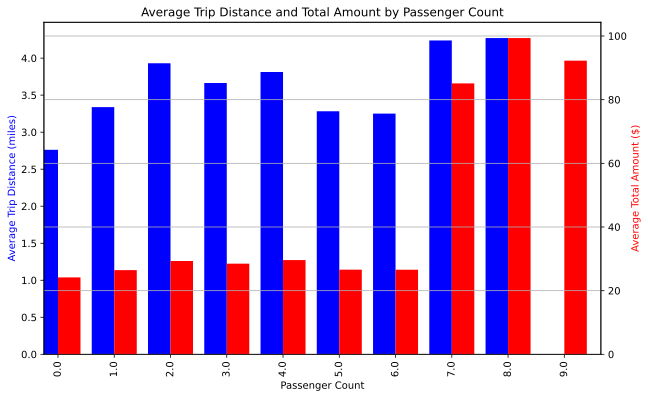

In [10]:
# Draw a bar chart of the average trip distance and total cost grouped by the number of passengers.
fig, ax1 = plt.subplots(figsize=(10, 6))
avg_distance_amount_by_passenger['trip_distance'].plot(kind='bar', color='blue', ax=ax1, position=1, width=0.4)
ax1.set_ylabel('Average Trip Distance (miles)', color='blue')
ax2 = ax1.twinx()
avg_distance_amount_by_passenger['total_amount'].plot(kind='bar', color='red', ax=ax2, position=0, width=0.4)
ax2.set_ylabel('Average Total Amount ($)', color='red')
plt.title('Average Trip Distance and Total Amount by Passenger Count')
ax1.set_xlabel('Passenger Count')
plt.grid(True)
plt.show()